In [1]:
import datetime
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import (
    Input,
    Embedding,
    Dense,
    Concatenate,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Activation,
    TextVectorization,
    GlobalAveragePooling1D,
)
from keras import optimizers, metrics, losses, Sequential
from keras.models import Model
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 123

images_path = "../../data/raw/images/image_train"

In [2]:
def plt_graph(training_history, run=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    range_epochs = np.arange(1, len(training_history.epoch) + 1, 1)

    # Courbe de la précision sur l'échantillon d'entrainement
    ax1.plot(
        range_epochs,
        training_history.history["accuracy"],
        label="Training Accuracy",
        color="blue",
    )

    ax1.plot(
        range_epochs,
        training_history.history["val_accuracy"],
        label="Validation Accuracy",
        color="orange",
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training and Validation Accuracy")
    ax1.legend()

    # Courbe de la précision sur l'échantillon de test
    ax2.plot(
        range_epochs,
        training_history.history["loss"],
        label="Training Loss",
        color="blue",
    )
    ax2.plot(
        range_epochs,
        training_history.history["val_loss"],
        label="Validation Loss",
        color="orange",
    )
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training and Validation Loss")
    ax2.legend()

    if run != None:
        id_exp = str(run.info.run_id)
    else:
        id_exp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Affichage de la figure
    plt.savefig(f"reports/figures/{id_exp}_training_history_DNN.png")

In [3]:
df = pd.read_csv("../../data/raw/x_train.csv", index_col=0)
df_target = pd.read_csv("../../data/raw/y_train.csv", index_col=0)
df[df_target.columns[0]] = df_target

df["text"] = np.where(
    df["description"].isna(),
    df["designation"].astype(str),
    df["designation"].astype(str) + " " + df["description"].astype(str),
)

df["image_name"] = df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
df["image_path"] = images_path + "/" + df["image_name"]

df.drop("designation", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)
df.drop("productid", axis=1, inplace=True)
df.drop("imageid", axis=1, inplace=True)
df.drop("image_name", axis=1, inplace=True)

num_classes = df["prdtypecode"].value_counts().shape[0]

target = df["prdtypecode"].astype("str")

target.value_counts(normalize=True)

prdtypecode
2583    0.120225
1560    0.059741
1300    0.059412
2060    0.058799
2522    0.058752
1280    0.057351
2403    0.056220
2280    0.056055
1920    0.050674
1160    0.046552
1320    0.038167
10      0.036695
2705    0.032514
1140    0.031455
2582    0.030489
40      0.029535
2585    0.029394
1302    0.029335
1281    0.024377
50      0.019796
2462    0.016734
2905    0.010269
60      0.009798
2220    0.009704
1301    0.009504
1940    0.009456
1180    0.008997
Name: proportion, dtype: float64

In [4]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["prdtypecode"].values, random_state=SEED
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["prdtypecode"].values, random_state=SEED
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 72602
Total validation examples: 3822
Total test examples: 8492


In [13]:
def imageGenerator(X_image, y_image, training=True):
    if training:
        # Configuration du générateur de données - Training set
        train_datagen = ImageDataGenerator(
            preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
            shear_range=0.2,
            zoom_range=0.1,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
        )
        # Préparation des générateurs
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=X_image.to_frame(name="image_path").join(
                y_image.to_frame(name="prdtypecode")
            ),
            x_col="image_path",
            y_col="prdtypecode",
            class_mode="categorical",
            target_size=(224, 224),
            batch_size=128,
        )
        return train_generator

    else:
        # Configuration du générateur de données - Validation set
        test_datagen = ImageDataGenerator(
            preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
        )

        test_generator = test_datagen.flow_from_dataframe(
            dataframe=X_image.to_frame(name="image_path").join(
                y_image.to_frame(name="prdtypecode")
            ),
            x_col="image_path",
            y_col="prdtypecode",
            class_mode="categorical",
            target_size=(224, 224),
            batch_size=128,
        )
        return test_generator

In [14]:
def custom_standardization(input_data):
    """
    Custom standardization function for text data.

    Args:
        input_data: The input text data.

    Returns:
        The standardized text data.
    """
    decoded_html = tf.strings.unicode_decode(input_data, "UTF-8")
    encoded_html = tf.strings.unicode_encode(decoded_html, "UTF-8")
    stripped_html = tf.strings.regex_replace(encoded_html, "<[^>]*>", " ")
    lowercase = tf.strings.lower(stripped_html)
    cleaned_input_data = tf.strings.regex_replace(lowercase, r"\s+", " ")
    return tf.strings.regex_replace(
        cleaned_input_data, "[%s]" % re.escape(string.punctuation), ""
    )


def preprocess_text(text_1):
    text_1 = tf.convert_to_tensor([text_1])
    output = custom_standardization(text_1)
    return output


def preprocess(sample, y, training):
    image = imageGenerator(sample["image_path"], y, training)
    text = preprocess_text(sample["text"])
    return {"text": text, "image": image}

In [15]:
batch_size = 128
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    columns = ["image_path", "text", "prdtypecode"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("prdtypecode")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.map(lambda x, y: (preprocess(x, y, training), y))
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [16]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

AttributeError: in user code:

    File "/var/folders/_z/rfghqg0j31d_t9y5_yrj2ss00000gn/T/ipykernel_13031/2315246440.py", line 10, in None  *
        lambda x, y: (preprocess(x, y, training), y)
    File "/var/folders/_z/rfghqg0j31d_t9y5_yrj2ss00000gn/T/ipykernel_13031/2616092721.py", line 28, in preprocess  *
        image = imageGenerator(sample["image_path"], y, training)
    File "/var/folders/_z/rfghqg0j31d_t9y5_yrj2ss00000gn/T/ipykernel_13031/999666015.py", line 14, in imageGenerator  *
        train_generator = train_datagen.flow_from_dataframe(

    AttributeError: 'SymbolicTensor' object has no attribute 'to_frame'


In [3]:
df = pd.read_csv("../../data/raw/x_train.csv", index_col=0)
df_target = pd.read_csv("../../data/raw/y_train.csv", index_col=0)
df[df_target.columns[0]] = df_target

df["text"] = np.where(
    df["description"].isna(),
    df["designation"].astype(str),
    df["designation"].astype(str) + " " + df["description"].astype(str),
)

df["image_name"] = df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
df["image_path"] = images_path + "/" + df["image_name"]

df.drop("designation", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)
df.drop("productid", axis=1, inplace=True)
df.drop("imageid", axis=1, inplace=True)
df.drop("image_name", axis=1, inplace=True)

num_classes = df["prdtypecode"].value_counts().shape[0]

target = df["prdtypecode"].astype("str")

# Séparation des données en ensembles d'entraînement et de test
# Text
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    df["text"], target, test_size=0.2, random_state=SEED
)
# Image
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(
    df["image_path"], target, test_size=0.2, random_state=SEED
)

X_train_text = np.expand_dims(X_train_text, axis=1)
X_test_text = np.expand_dims(X_test_text, axis=1)

# Encode
le = LabelEncoder()
y_train_text = le.fit_transform(y_train_text)
y_test_text = le.transform(y_test_text)

# Vectorize
y_train_text = to_categorical(y_train_text, num_classes)
y_test_text = to_categorical(y_test_text, num_classes)

print("\ny_train shape:", y_train_text.shape)

y_train_1d = np.argmax(y_train_text, axis=1)

# Appliquer des poids aux classes selon l'équilibrage du dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_1d), y=y_train_1d
)

# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = dict(zip(np.unique(y_train_1d), class_weights))

# Défnit la longueur de la séquence du model
# Vocabulary size and number of words in a sequence.
# median = 320
# mean = 600
df["len"] = df["text"].str.len()
sequence_length = 5000
print("\nsequence_length:", sequence_length, "\n")

# Pour libérer de la RAM
del df, df_target, target

X_train_text = tf.strings.as_string(X_train_text)
X_test_text = tf.strings.as_string(X_test_text)


y_train shape: (67932, 27)

sequence_length: 5000 



2024-04-25 11:33:19.602198: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-25 11:33:19.602221: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-25 11:33:19.602227: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-25 11:33:19.602419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 11:33:19.602430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


# Define layers

In [25]:
vectorize_layer.output

<KerasTensor shape=(None, 5000), dtype=int64, sparse=False, name=keras_tensor_502>

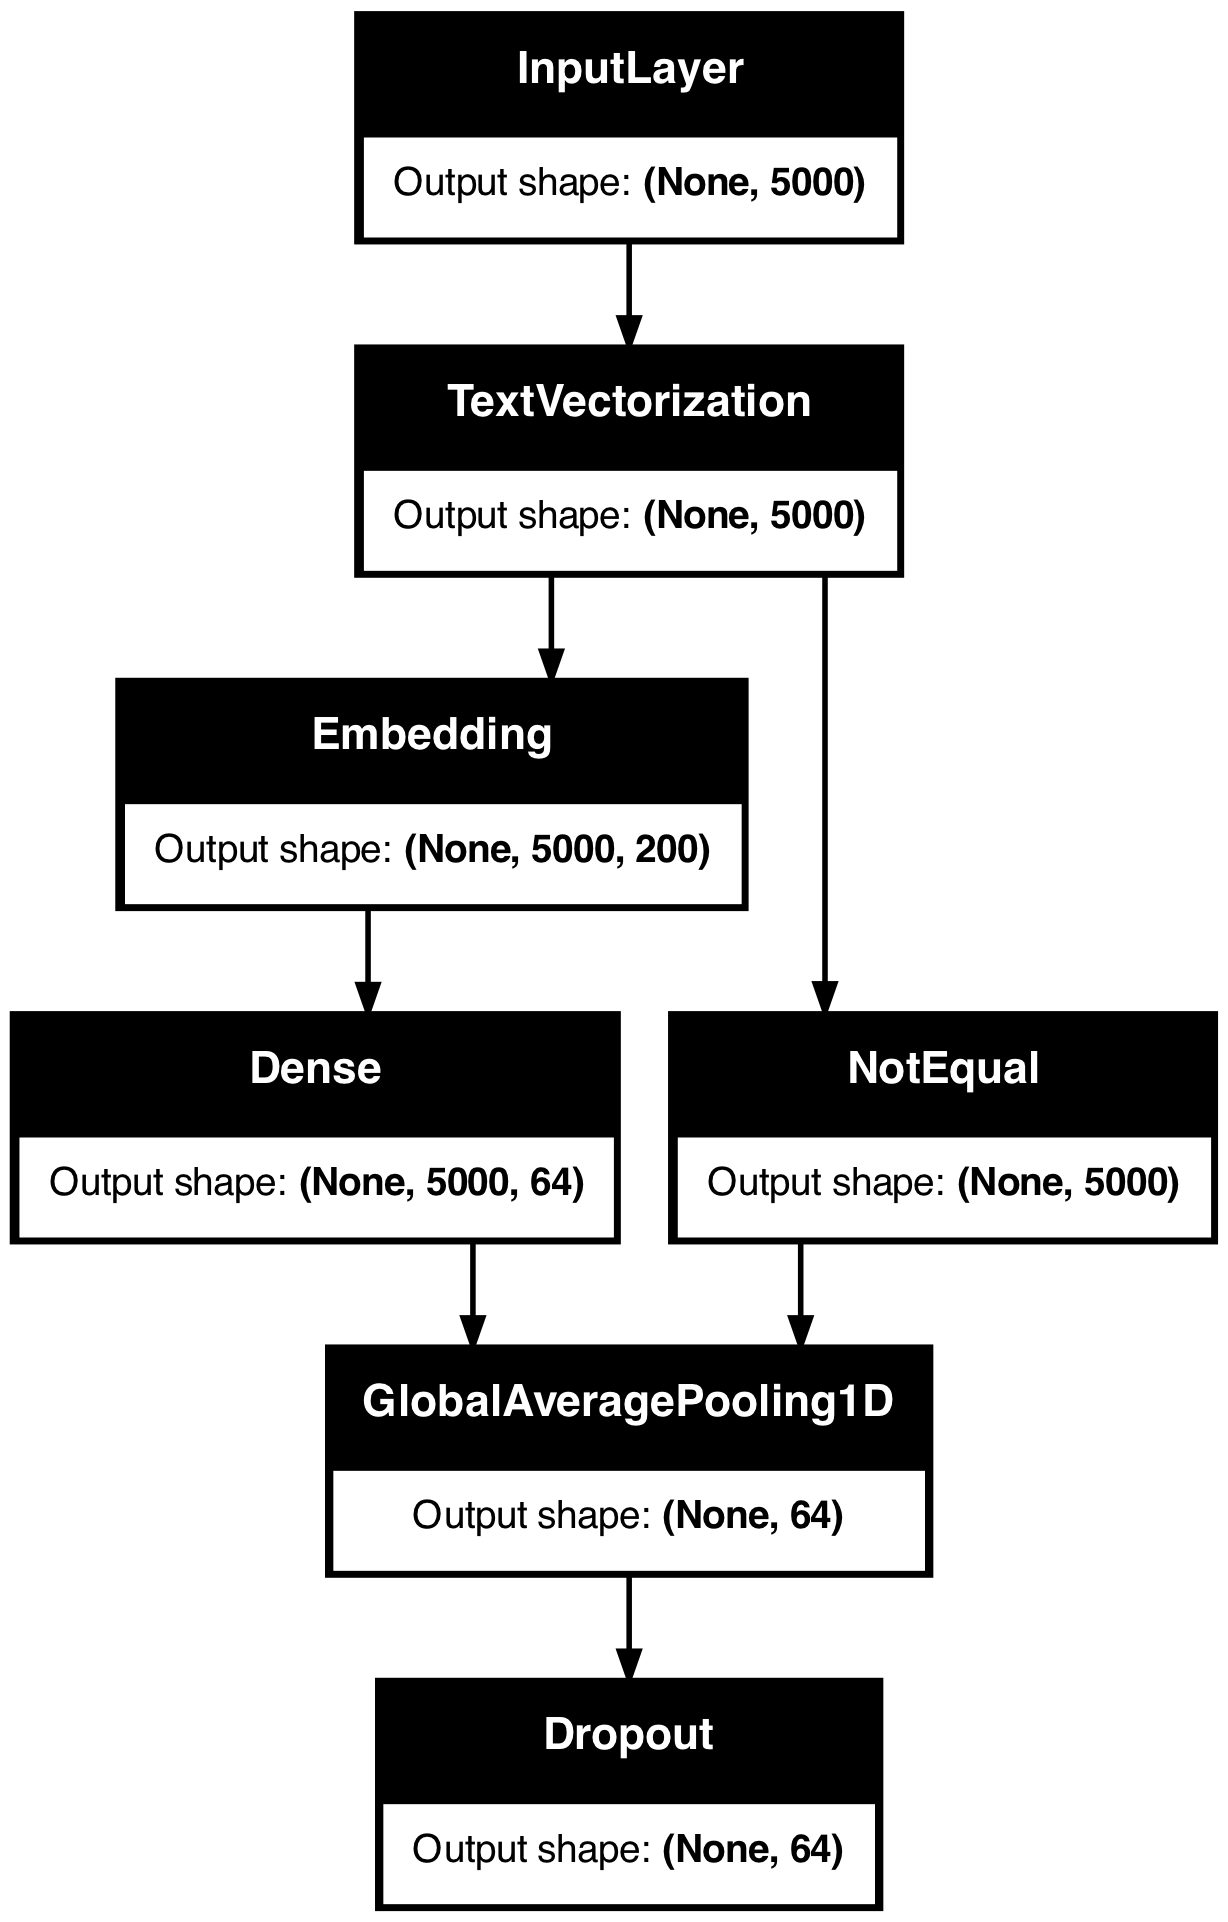

In [27]:
# TEXTS
inputs_t = Input(
    (sequence_length,),
    dtype=str,
    name="Input texts",
)
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=100000,
    output_mode="int",
    output_sequence_length=sequence_length,
)
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
vectorize_layer.adapt(X_train_text)
vectorize_layer(inputs_t)
# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
# vectorize_layer.adapt(X_train_text)

embedding_t = Embedding(sequence_length, 200, mask_zero=True)(vectorize_layer.output)
dense1_t = Dense(64, activation="relu")(embedding_t)
gap1D_t = GlobalAveragePooling1D()(dense1_t)
dropout_t = Dropout(0.5)(gap1D_t)
# outputs_t = Dense(num_classes, activation="softmax")

text_encoder = Model(inputs_t, dropout_t, name="text encoder")
utils.plot_model(text_encoder, show_shapes=True)

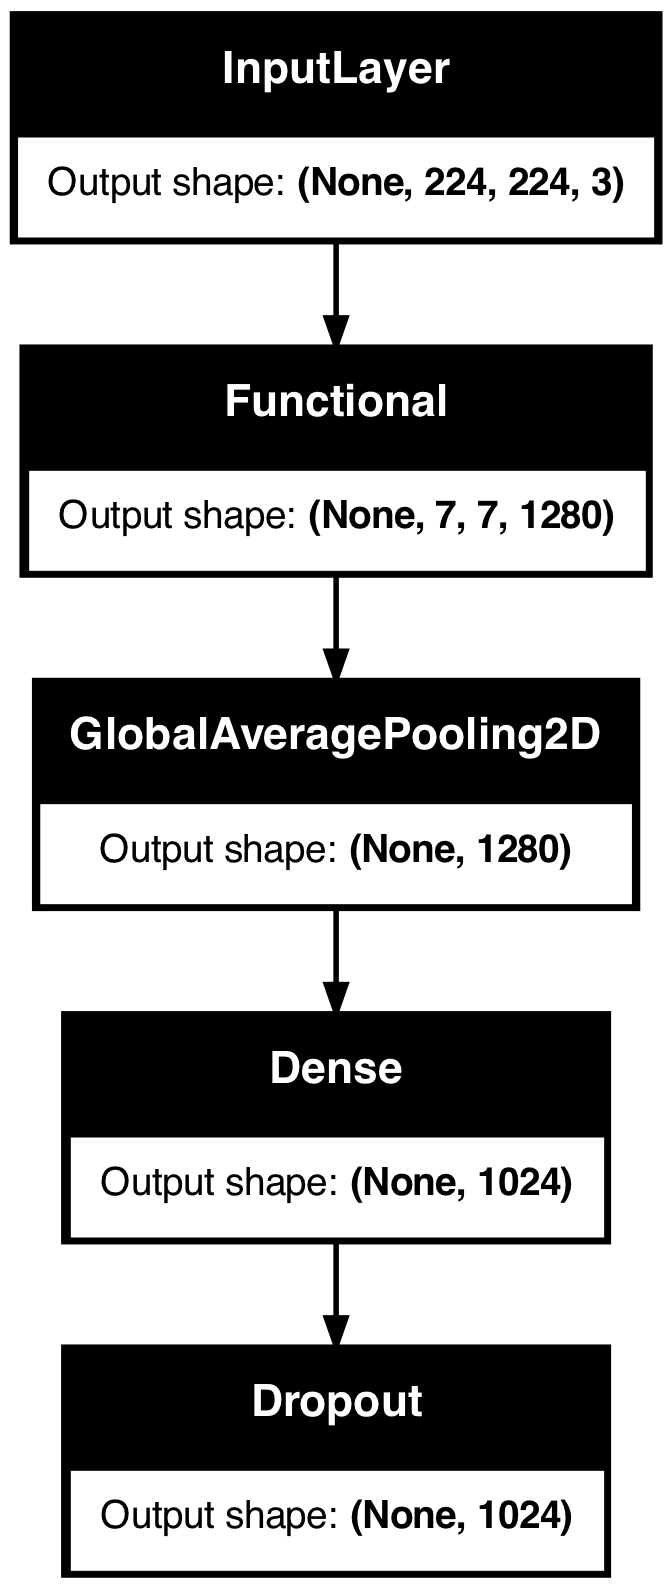

In [13]:
inputs_i = Input(
    (
        224,
        224,
        3,
    ),
    name="Input images",
)

efficientNetB0_i = EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3))
)(inputs_i)

# Ajout des couches personnalisées
gap2D_i = GlobalAveragePooling2D()(efficientNetB0_i)
dense1_i = Dense(1024, activation="relu")(gap2D_i)
dropout_i = Dropout(0.5)(
    dense1_i
)  # taux de dropout à 0.5 pour réduire le surapprentissage
# predictions = Dense(len(y_train.unique()), activation="softmax")(x)

image_encoder = Model(inputs_i, dropout_i, name="image encoder")
utils.plot_model(image_encoder, show_shapes=True)

In [14]:
# Concatenate the processed inputs:
merged = Concatenate(axis=1)([text_encoder, image_encoder])

# Add dense layers and output:
output = Dense(num_classes, activation="softmax")(merged)

# Create the model:
model = Model(inputs=[inputs_t, inputs_i], outputs=output)
utils.plot_model(image_encoder, show_shapes=True)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Functional name=text encoder, built=True> (of type <class 'keras.src.models.functional.Functional'>)

In [12]:
# Compile the model
opt = optimizers.Adam(0.001)
loss = losses.CategoricalCrossentropy()
f1_score = metrics.F1Score(average="weighted")
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=["accuracy", f1_score],
)

In [13]:
# Callbacks
early_stopping = EarlyStopping(
    patience=4,  # Attendre n epochs avant application
    min_delta=0.0001,  # si au bout de n epochs la fonction de perte ne varie pas de n %,
    # que ce soit à la hausse ou à la baisse, on arrête
    verbose=1,  # Afficher à quel epoch on s'arrête
    monitor="val_loss",
    start_from_epoch=5,
)
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,  # si val_loss stagne sur n epochs consécutives selon la valeur min_delta
    min_delta=0.005,
    min_lr=0.00001,
    factor=0.1,  # On réduit le learning rate d'un facteur n
    cooldown=2,  # On attend n epochs avant de réitérer
    verbose=1,
)

# Train the model
training_history = model.fit(
    [X_train_text, X_train_image],
    [y_train_text, y_train_image],
    epochs=20,
    batch_size=128 * 4,
    validation_data=([X_test_text, X_test_image], [y_test_text, y_test_image]),
    callbacks=[reduce_learning_rate, early_stopping],
    # class_weight=class_weight_dict,
)
plt_graph(training_history, None)

Epoch 1/20


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(None, 1), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None, 1)[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(None, 1), dtype=string)', 'tf.Tensor(shape=(None, 1), dtype=string)')
  • training=True
  • mask=('None', 'None')

https://keras.io/examples/nlp/multimodal_entailment/#model-building-utilities